![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 10 - RNN</center>
### <center> Vanilla RNN</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN/MainVanillaRNN.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn          as nn
import torch.optim       as optim
import torchsummary

from torch.optim import lr_scheduler

matplotlib.rc('font', **{'size' : 16})

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/10_RNN/DeepLearningFramework ./DeepLearningFramework

### PyTorch `PackedSequence`:

In [4]:
from torch.nn.utils.rnn import pack_sequence

v1 = torch.tensor([1, 2, 3])
v2 = torch.tensor([4])
v3 = torch.tensor([5, 6])
lV = [v1, v2 ,v3]

pack = pack_sequence(lV, enforce_sorted=False)
print('pack.data          :', pack.data)
print('pack.batch_sizes   :', pack.batch_sizes)
print('pack.sorted_indices:', pack.sorted_indices)

pack.data          : tensor([1, 5, 4, 2, 6, 3])
pack.batch_sizes   : tensor([3, 2, 1])
pack.sorted_indices: tensor([0, 2, 1])


### Basic example
* Random data with random length.
* The goal is to estimate the sequence's length.

#### Generate data:

In [5]:
#-- Min and max lengths:
minL   = 2
maxL   = 100

nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

#-- Generate random lengths:
lX = [None] * N
vY = torch.randint(minL, maxL, (N,))
for ii in range(N):
    vXi    = torch.randn(vY[ii], 1)
    lX[ii] = vXi

#### Dataset:

In [6]:
#-- A simple sequence dataset:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, lX, vY):
        self.lX = lX
        self.vY = vY
        
    def __len__(self):
        return len(self.lX)
    
    def __getitem__(self, idx):
        vXi = self.lX[idx]
        yi  = self.vY[idx]
        return vXi, yi

In [7]:
lTrainX = lX[:nTrain]
vTrainY = vY[:nTrain]
lTestX  = lX[nTrain:]
vTestY  = vY[nTrain:]

oTrainSet = SequenceDataset(lTrainX, vTrainY.float())
oTestSet  = SequenceDataset(lTestX,  vTestY .float())

#### Data loader:
We gonna use `zip` to implement the `collate_fn`

In [8]:
l = [(1, 'a'), (2, 'b'), (3, 'c')]
l1, l2 = zip(*l)
l1, l2

((1, 2, 3), ('a', 'b', 'c'))

In [9]:
def SequenceCollateFunction(lBatch):
    
    lX, lY = zip(*lBatch)
    vY     = torch.tensor(lY, dtype=torch.float32)
    mPackX = pack_sequence(lX, enforce_sorted=False)
    
    return mPackX, vY


batchSize = 128
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=SequenceCollateFunction)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=SequenceCollateFunction)

In [10]:
(lX, vY) = next(iter(oTrainDL))

lX.data.shape, vY.shape

(torch.Size([6730, 1]), torch.Size([128]))

### RNN Model:

In [11]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 80
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
                                   #-- mPackX.shape = (N*T,)
        _, mH  = self.oRnn(mPackX) #-- mH    .shape = (1, N, H)
        vY     = self.oFC (mH[0])  #-- vY    .shape = (N, 1)
        
        return vY[:,0]

mPackX, vY = next(iter(oTrainDL))
RnnModel()(mPackX).shape

torch.Size([128])

#### Device and loss:

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()

### Train the model:

In [13]:
from torch.optim                    import lr_scheduler
from DeepLearningFramework.Training import TrainRegressionModel

nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)
oModel        = RnnModel().to(DEVICE)
oOptim        = optim.Adam(oModel.parameters(), lr=5e-6, betas=(0.8, 0.9))
oScheduler    = lr_scheduler.OneCycleLR(oOptim, max_lr=5e-4, total_steps=nIter)
lHistory      = TrainRegressionModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler);

Epoch 000: | Train loss: 3322.08108 | Val loss: 3254.07151 | Train R2: -3.1958 | Val R2: -3.1001 | epoch time:  5.166 | <-- Checkpoint!
Epoch 001: | Train loss: 3039.35241 | Val loss: 2825.68529 | Train R2: -2.8390 | Val R2: -2.5601 | epoch time:  4.391 | <-- Checkpoint!
Epoch 002: | Train loss: 2664.42198 | Val loss: 2485.03726 | Train R2: -2.3591 | Val R2: -2.1307 | epoch time:  4.051 | <-- Checkpoint!
Epoch 003: | Train loss: 2345.77135 | Val loss: 2055.13854 | Train R2: -1.9574 | Val R2: -1.5888 | epoch time:  4.407 | <-- Checkpoint!
Epoch 004: | Train loss: 2319.86865 | Val loss: 1893.87949 | Train R2: -1.9288 | Val R2: -1.3861 | epoch time:  3.876 | <-- Checkpoint!
Epoch 005: | Train loss: 2761.25886 | Val loss: 3768.19335 | Train R2: -2.5015 | Val R2: -3.7465 | epoch time:  3.553 |
Epoch 006: | Train loss: 1896.62504 | Val loss: 1145.19257 | Train R2: -1.3980 | Val R2: -0.4418 | epoch time:  3.837 | <-- Checkpoint!
Epoch 007: | Train loss: 2643.95840 | Val loss: 4085.87860 | Tra

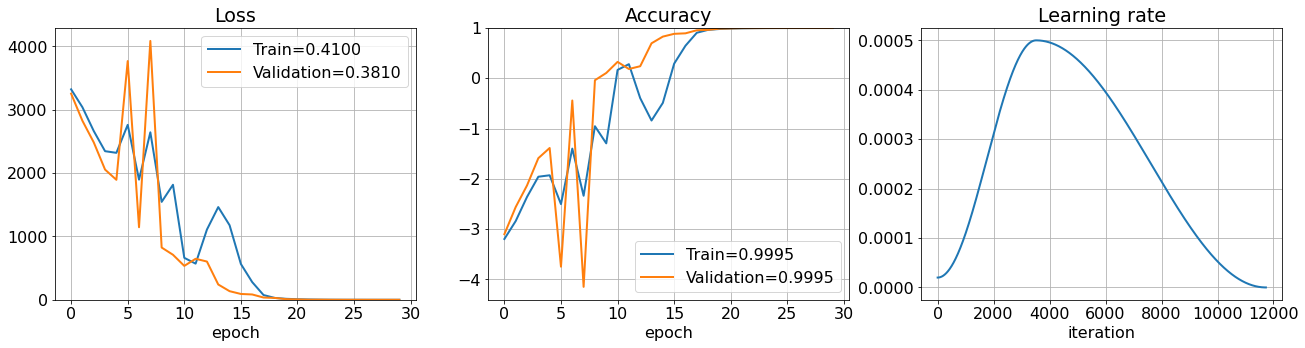

In [14]:
from DeepLearningFramework.Auxiliary import PlotHistory

PlotHistory(lHistory)

### Test the model:

In [15]:
L      = np.random.randint(minL, maxL)
vX     = pack_sequence([torch.randn(L, 1)])
y      = oModel(vX.to(DEVICE))
print(f'Sequence length           = {L}')
print(f'Estimated sequence length = {y.item()}')

Sequence length           = 65
Estimated sequence length = 65.15986633300781


### Exercise
* The goal is to estimate the following function:
![f_x](https://github.com/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/10_RNN//f_x.png?raw=true)
* Train an RNN model and get $R^2$ above `0.99`.

#### Generate data:

In [16]:
minL   = 5
maxL   = 30
nTrain = 50000
nTest  = 10000
N      = nTrain + nTest

vY = torch.zeros(N)
lX = [None] * N
for ii in range(N):
    L       = np.random.randint(minL, maxL)
    vX      = torch.rand(L, 1)
    idx     = np.random.randint(L)
    vX[idx] = -1
    lX[ii]  = vX
    vY[ii]  = torch.sum(vX[:idx]**2) - torch.sum(vX[idx+1:]**2)

In [ ]:
lTrainX = lX[:nTrain]
vTrainY = vY[:nTrain]
lTestX  = lX[nTrain:]
vTestY  = vY[nTrain:]

In [17]:
oTrainSet = ???
oTestSet  = ???

In [18]:
batchSize = ???
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=batchSize,   collate_fn=???)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, collate_fn=???)

### Model:

In [23]:
class RnnModel(nn.Module):
    def __init__(self):
        super(RnnModel, self).__init__() #-- always do this
        
        H         = 100
        self.oRnn = nn.RNN   (input_size=1, hidden_size=H, batch_first=True, num_layers=5)
        self.oFC  = nn.Linear(H, 1)

    def forward(self, mPackX):
        ???

lX, vY = next(iter(oTrainDL))
RnnModel()(lX).shape

Object `?` not found.


AttributeError: 'NoneType' object has no attribute 'shape'

In [20]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
Loss   = nn.MSELoss()

In [24]:
from torch.optim                    import lr_scheduler
from DeepLearningFramework.Training import TrainRegressionModel

nEpochs       = 30
nIter         = nEpochs * len(oTrainDL)
oModel        = RnnModel().to(DEVICE)
oOptim        = ???
oScheduler    = ???
lHistory      = TrainRegressionModel(oModel, oTrainDL, oTestDL, Loss, nEpochs, oOptim, oScheduler);

SyntaxError: invalid syntax (<ipython-input-24-c6d8675da41b>, line 7)

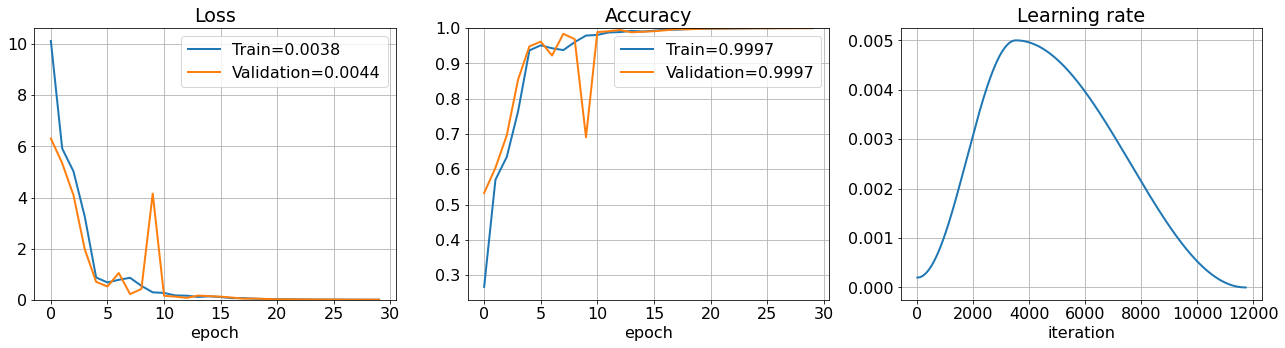

In [25]:
PlotHistory(lHistory)